In [ ]:
# ML_in_Finance_LSPI_Markowitz
# Author: Matthew Dixon
# Version: 1.0 (06.05.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 and the following packages:
# matplotlib=3.1.3, pandas=1.0.3, numpy=1.18.1, scipy=1.4.1, bspline=0.1.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## Mean-Variance Optimization with risky asset and cash

In [27]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import norm

from bspline import Bspline, splinelab

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters for MC simulation of stock prices

In [2]:
S0 = 100 # Initial stock price
mu = 0.03 # Drift
sigma = 0.20 # Volatility
r = 0.01 # Risk-free rate
M = 1 # Maturity

T = 30 # Number of time steps
delta_t = M / T # Time interval

N_MC = 2000 # Number of paths

gamma = np.exp(- r * delta_t) # Discount factor
lmbda = 10.0 # Risk aversion
alpha = 1.0 # Learning rate

## Create dataset

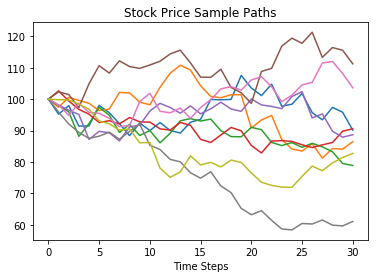

In [3]:
# Stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:, 0] = S0

# Standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:, t] = S.loc[:, t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])
    
    # Or, using Euler for alpha-stable distributions:
    #S.loc[:, t] = S.loc[:, t-1]*(1 + mu*delta_t + sigma *S.loc[:,t-1]**(alpha-1)*np.sqrt(delta_t) * RN.loc[:,t])

# Plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


$$C_t = -R_t= -r_t  + \lambda (r_t-\mu)^2  =  -(1-u_t)r_f - u_t  \phi_t  +  \lambda u_t^2 Var(\phi_t | S_t)$$ 

In [4]:
def negative_reward(mu, var, a, rf, lmbda):
    C = -(1-a)*rf - a*mu + lmbda*(a**2)*var
    return C

##  Define spline basis functions  

In [5]:
X = S # set the wealth (but not the total wealth) of the portfolio to be the stock price
p = 4 # order of spline (as-is; 3 = cubic, 4: B-spline)
ncolloc = 16
a_min = -1
a_max = 1

In [26]:
def get_basis_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we
    tau_a = np.linspace(a_min, a_max, ncolloc)  # would like to interpolate

    # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
    # To get meaninful results, one should have ncolloc >= p+1
    k_x = splinelab.aptknt(tau_x, p)
    k_a = splinelab.aptknt(tau_a, p)
                             
    # Spline basis of order p on knots k
    basis_x = Bspline(k_x, p)
    basis_a = Bspline(k_a, p)
    return basis_x, basis_a

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [7]:
num_t_steps = T + 1
num_basis =  ncolloc**2 

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))

In [8]:
x = X.values[:, 0]
np.shape(x)

(2000,)

## Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\Phi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\left(C\left(X_t^k,a_t^k,X_{t+1}^k\right)+\gamma\min_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1}^k,a_{t+1}^k\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

In [9]:
def function_S_vec(t, data_mat_t):
    # Compute the matrix S_{nm} 
    X_mat = data_mat_t[t, :, :]
    num_basis_funcs = X_mat.shape[1]    
    S_mat = np.dot(X_mat.T, X_mat)
    return S_mat

def function_M_vec(t, Q, R, data_mat_t, gamma=0.1):
    X_mat = data_mat_t[t,:,:]
    tmp = R + gamma * np.min(Q[:, t+1])  # note that the second argument in Q is t+1
    M = np.dot(X_mat.T, tmp)
    return M

### Least Squares Policy Iteration
Call *function_S* and *function_M* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t,a_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t,a_t^\star\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=0$.



#### Initialize data structures

In [10]:
mu = np.zeros(T)
var = np.zeros(T)

# optimal action
a_opt = np.zeros((N_MC, T))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:, -1] = 0

# optimal Q-function with optimal action
max_Q_star = np.zeros((N_MC, T))

a_mean = []

#### initialize actions in feasible region [0, a_max]

In [11]:
grid_size_x = 20
grid_size_a = 500 

# set up a small grid, sufficiently nested inside the support of the basis functions
a_min_prime = a_min + 0.1
a_max_prime = a_max - 0.1

a_grid = np.linspace(a_min_prime, a_max_prime, grid_size_a)

Q_star = np.zeros((N_MC, T))
tau = 1e-6
a = a_min_prime + (a_max_prime - a_min_prime) * np.random.rand(N_MC)

There are *grid_size_x* $\times$ *grid_size_a* inner grid points and 256 basis functions. Let $(k,l)$ denote the indices of the smaller grid $\Omega^h$. Let $(i,j)$ denote the indices of the knot points of the basis functions. If you sum over the last index, then you can check the interpolation of ones
$$f(x_k,a_l)=\sum_{ij} \Phi(x_k,a_l)f_{ij}$$
check if $f_{ij}=1$ everywhere
$$f(x,a)=\sum_{ij} \Phi(x,a)1 =1, \forall x,a ?$$

#### The backward loop

*Make sure to rerun cells under the heading* **'Initialize data structures'** *to reset the initial conditions before running this cell*

In [28]:
for t in np.arange(T - 2, 0, -1):
    error = tau
    q_prev = np.zeros(N_MC)  
    ret = (S.loc[:, t+1] - S.loc[:, t]) / S.loc[:, t]
    mu[t] = np.mean(ret)
    var[t] = np.var(ret)
    count = 0
    max_iter = 100
    x = X.values[:, t]
    basis_x, basis_a = get_basis_functions(np.min(x)-10, np.max(x)+10, a_min, a_max, ncolloc, p)
    x_grid = np.linspace(np.min(x), np.max(x), grid_size_x)
    Phi_mat = np.array([[np.kron(basis_x(x_grid[i]), basis_a(a_grid[j])).reshape(num_basis, 1) 
                         for i in range(grid_size_x)] for j in range(grid_size_a)])[:, :, :, 0]   
        
    while (np.abs(error)>=tau) and (count<max_iter):
       
        R = negative_reward(mu[t], var[t], a, r, lmbda)
        data_mat_t[t, :, :] = np.array([np.kron(basis_x(x[i]), basis_a(a[i])).reshape(num_basis, 1) for i in range(N_MC)])[:, :, 0]
        
        # Check partition of unity
        h = np.dot(data_mat_t[t],np.ones(np.shape(data_mat_t[t])[1]))
        if np.sum(h) != N_MC:
            print("error: loss of partition of unity")
        S_t = function_S_vec(t, data_mat_t) 
        M_t = function_M_vec(t, Q_star, R, data_mat_t, gamma)
        W_t = np.dot(np.linalg.pinv(S_t), M_t)
       
        # Compute Q_t matrix over small grid
        # Phi_mat is the matrix for interpolating over the smaller x * a grid
        Q_t = np.dot(Phi_mat, W_t) # gridded Q_t
        
        print("residual error: ||r||=||Sw-M||")
        print(np.linalg.norm(np.dot(S_t, W_t) - M_t))
        
        # Find the optimal action on the small grid
        a_idx =  np.argmin(Q_t, axis=0)
        # Need to interpolate over X 
        a_star_ = np.zeros(grid_size_x, dtype='float64')
        
        for j in range(grid_size_x):
            a_star_[j] = a_grid[a_idx[j]]
    
        f = interp1d(x_grid, a_star_, kind='cubic')
        a_prime = f(x)
        
        # Only update the actions along the paths where the neg. reward is lowered
        R_prime = negative_reward(mu[t], var[t], a_prime, r, lmbda)
        idx = np.where(R_prime>R)
        a_prime[idx] = a[idx]
        a = a_prime
        a_mean.append(np.mean(a))
        Q_star[:,t] = np.dot(data_mat_t[t, :, :], W_t)
        error = np.linalg.norm(Q_star[:, t] - q_prev)
        
        q_prev = np.copy(Q_star[:, t])
        
        print('count, Q error, E[R], E[a]')
        print(count, error, np.mean(R), np.mean(a))
        count += 1 
       
    a_opt[:, t] = a  

residual error: ||r||=||Sw-M||
0.000398707563600478
count, Q error, E[R], E[a]
0 0.5061887610865609 -0.011319156048994788 -0.3192495279245068
residual error: ||r||=||Sw-M||
0.0035774468126113664
count, Q error, E[R], E[a]
1 0.0003894662371039228 -0.011319689000950553 -0.3192447507268801
residual error: ||r||=||Sw-M||
0.00045313638829628546
count, Q error, E[R], E[a]
2 0.0003979698543490594 -0.011319689411180346 -0.3192436332651927
residual error: ||r||=||Sw-M||
0.0006786825420458005
count, Q error, E[R], E[a]
3 9.059580018232614e-05 -0.011319689487828095 -0.31924482064166826
residual error: ||r||=||Sw-M||
0.0006969864403854024
count, Q error, E[R], E[a]
4 2.748086109753775e-05 -0.011319689493547745 -0.31925861120654586
residual error: ||r||=||Sw-M||
0.000885396575728253
count, Q error, E[R], E[a]
5 5.2197837682137965e-05 -0.011319689534683867 -0.31927718273006694
residual error: ||r||=||Sw-M||
0.017037175640146826
count, Q error, E[R], E[a]
6 0.0016131945283645694 -0.011319689633372208

residual error: ||r||=||Sw-M||
0.009949286332704173
count, Q error, E[R], E[a]
11 0.0008663423983455406 -0.011206506690236736 -0.3057507180425872
residual error: ||r||=||Sw-M||
0.0023479641577421814
count, Q error, E[R], E[a]
12 0.0010418216937681372 -0.011206506913263733 -0.3057446717563878
residual error: ||r||=||Sw-M||
0.011885334600403611
count, Q error, E[R], E[a]
13 0.0012191618162531268 -0.011206507043375464 -0.3057796967374055
residual error: ||r||=||Sw-M||
0.0045674776082202315
count, Q error, E[R], E[a]
14 0.0013176266260941831 -0.01120650810843167 -0.30578126590831267
residual error: ||r||=||Sw-M||
0.005342788231673597
count, Q error, E[R], E[a]
15 0.0008045874906002381 -0.011206508927928464 -0.30578304152070557
residual error: ||r||=||Sw-M||
0.008212546782483048
count, Q error, E[R], E[a]
16 0.0006817184748365771 -0.0112065089701279 -0.30587684337045823
residual error: ||r||=||Sw-M||
0.00353020496964982
count, Q error, E[R], E[a]
17 0.0006070910693196417 -0.0112065120983849

residual error: ||r||=||Sw-M||
0.01081646976445706
count, Q error, E[R], E[a]
34 0.0007712394993710514 -0.010995249708779124 -0.26276641901797526
residual error: ||r||=||Sw-M||
0.01100777937094434
count, Q error, E[R], E[a]
35 0.0005358421412269437 -0.010995252219031481 -0.2627692442605615
residual error: ||r||=||Sw-M||
0.007254617075675654
count, Q error, E[R], E[a]
36 0.0015531689238674014 -0.010995252328285346 -0.26277357924568184
residual error: ||r||=||Sw-M||
0.015708930126824013
count, Q error, E[R], E[a]
37 0.0019120173071396655 -0.010995252667850865 -0.26277982903693603
residual error: ||r||=||Sw-M||
0.01663227205477561
count, Q error, E[R], E[a]
38 0.002617648085639215 -0.010995252830892848 -0.262785746622708
residual error: ||r||=||Sw-M||
0.006681364976897025
count, Q error, E[R], E[a]
39 0.001994888596736338 -0.010995252936836524 -0.2628186635241113
residual error: ||r||=||Sw-M||
0.007852986014821688
count, Q error, E[R], E[a]
40 0.0011365430669912353 -0.010995253421039767 -

0.044078111000364004
count, Q error, E[R], E[a]
30 0.007151130941954128 -0.011895410039684204 -0.38169453383749147
residual error: ||r||=||Sw-M||
0.030003397064164564
count, Q error, E[R], E[a]
31 0.0061438369726651305 -0.011895410077852352 -0.3816953165633919
residual error: ||r||=||Sw-M||
0.03361140399229209
count, Q error, E[R], E[a]
32 0.005472665149654474 -0.011895410079109657 -0.3816965915833014
residual error: ||r||=||Sw-M||
0.041586418975544145
count, Q error, E[R], E[a]
33 0.0017926817572905024 -0.011895410103752299 -0.38169933368173936
residual error: ||r||=||Sw-M||
0.021942278018980382
count, Q error, E[R], E[a]
34 0.004027951169567761 -0.011895410127370495 -0.3816992881298046
residual error: ||r||=||Sw-M||
0.016085406691556142
count, Q error, E[R], E[a]
35 0.0039107695001910124 -0.011895410144405233 -0.3816995894627648
residual error: ||r||=||Sw-M||
0.049893112093528126
count, Q error, E[R], E[a]
36 0.0068002202136327895 -0.011895410159345815 -0.38170212437534495
residual e

0.08309356426305492
count, Q error, E[R], E[a]
9 0.00837400363578888 -0.011521030634602017 -0.33728996550599283
residual error: ||r||=||Sw-M||
0.039131416444490884
count, Q error, E[R], E[a]
10 0.01020299283212323 -0.011521030640810738 -0.3372916047261896
residual error: ||r||=||Sw-M||
0.05281781175196676
count, Q error, E[R], E[a]
11 0.00774787781216505 -0.01152103064441474 -0.337293956428713
residual error: ||r||=||Sw-M||
0.025973702482152933
count, Q error, E[R], E[a]
12 0.00621747522343324 -0.011521030649466708 -0.3373031393731415
residual error: ||r||=||Sw-M||
0.028649135445299782
count, Q error, E[R], E[a]
13 0.005581825156813068 -0.011521030667599984 -0.33730632465280563
residual error: ||r||=||Sw-M||
0.025809121258235472
count, Q error, E[R], E[a]
14 0.004036605019982964 -0.011521030674986409 -0.3373065205204443
residual error: ||r||=||Sw-M||
0.05391604534472865
count, Q error, E[R], E[a]
15 0.003416232533436945 -0.011521030675028207 -0.3373103951173246
residual error: ||r||=||

residual error: ||r||=||Sw-M||
0.0009646423877153412
count, Q error, E[R], E[a]
1 0.0020086343911335106 -0.011928364185853883 -0.3628408641623124
residual error: ||r||=||Sw-M||
0.004075955136214058
count, Q error, E[R], E[a]
2 0.0005438082203883865 -0.011932336831248721 -0.3679730851056018
residual error: ||r||=||Sw-M||
0.011468255880279811
count, Q error, E[R], E[a]
3 0.0013293908727078734 -0.011933927644602977 -0.37057034246030396
residual error: ||r||=||Sw-M||
0.0010142910656508967
count, Q error, E[R], E[a]
4 0.0010248500141787512 -0.011934363736331373 -0.37615821645221775
residual error: ||r||=||Sw-M||
0.005115440578758735
count, Q error, E[R], E[a]
5 0.000602411884229328 -0.011935055962879793 -0.3761845717794355
residual error: ||r||=||Sw-M||
0.015813804311447646
count, Q error, E[R], E[a]
6 0.0016656958871009264 -0.01193505845795309 -0.3763039478895638
residual error: ||r||=||Sw-M||
0.008853106567154467
count, Q error, E[R], E[a]
7 0.0023943451249224808 -0.011935063003482523 -0.

KeyboardInterrupt: 

In [15]:
a_star_exact = []
a_star_approx = []
for t in range(1, T-1):
    a_star_exact.append((mu[t] - r) / (2 * lmbda * var[t]))
    a_star_approx.append(np.mean(a_opt[:, t]))

Text(0, 0.5, 'action')

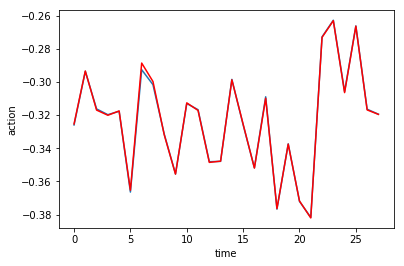

In [16]:
plt.plot(a_star_approx)
plt.plot(a_star_exact, color='red')
plt.xlabel('time')
plt.ylabel('action');

In [17]:
a_star_exact = (mu[t] - r) / (2 * lmbda * var[t])

In [18]:
a_star_exact

-0.3195399492486123

In [19]:
negative_reward(mu[t], var[t], a_star_exact, r, lmbda)

-0.011319690628406131

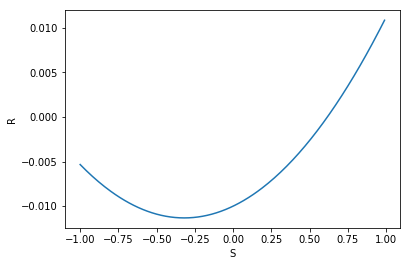

In [20]:
a_ = np.arange(-1, 1, 0.01)
plt.plot(a_, negative_reward(mu[t], var[t], a_, r, lmbda))
plt.xlabel('S')
plt.ylabel('R');

In [ ]:
plt.plot(a_mean)
plt.plot(x_grid, a_star_)
plt.plot(x_grid, np.ones(len(x_grid)) * a_star_exact, color='black')
plt.ylim([-1, 1])

optimal action depends on lambda